####  Setup

In [3]:
import pandas as pd
import os
import math
import json
import matplotlib.pyplot as plt 
corpus_dir = 'corpus/'

In [4]:
corpus_files = os.listdir(corpus_dir) 
corpus_files = [file for file in corpus_files if file.endswith(".csv")]

### Valid Responses Data

Contabilizamos para cada ejecución la cantidad de respuestas válidas por bloque.

Respuestas válidas != Respuestas correctas. Válidas para el tono: ["A", "S"] y para el número: ["J", "K"].

In [122]:
if not os.path.exists("metadata.csv"):
    df = pd.DataFrame(columns=["date", "gender", "hand", "age", "response_amount_block_1", "response_amount_block_2", "response_amount_block_3", "response_amount_block_4", "total_response_amount"])
    for file in corpus_files:
        file_df = pd.read_csv(f"{corpus_dir}/{file}")

        file_df = file_df.dropna(subset=['rt_1'])
        file_df = file_df.dropna(subset=['rt_2'])
        percentage = (file_df['rt_1'] > file_df['delay']).mean()
        if percentage >=.8:
            print(f"Delay < RT_1 for {file}")
            continue
        if (file_df.apply(lambda row: row.rt_2+row.delay, axis=1).mean() > 2000):
            print(f"rt2 > 2000 for {file}")
            continue
        file = file.split(".")[-2]
        date, gender, hand, age = file.split("_")[1:]
        gender = "woman" if gender == "Mujer" else "man"
        hand = "right" if hand == "Derecha" else "left"
        count_block = lambda block_number : sum(file_df['block'] == block_number)
        b1, b2, b3, b4 = count_block(0), count_block(1), count_block(2), count_block(3)
        df.loc[len(df.index)] = [date, gender, hand, int(age), 
                                    b1, b2, 
                                    b3, b4, 
                                    len(file_df)]
        
    df.to_csv("metadata.csv")
else:
    df = pd.read_csv("metadata.csv")

Text(0.5, 1.0, 'Gender')

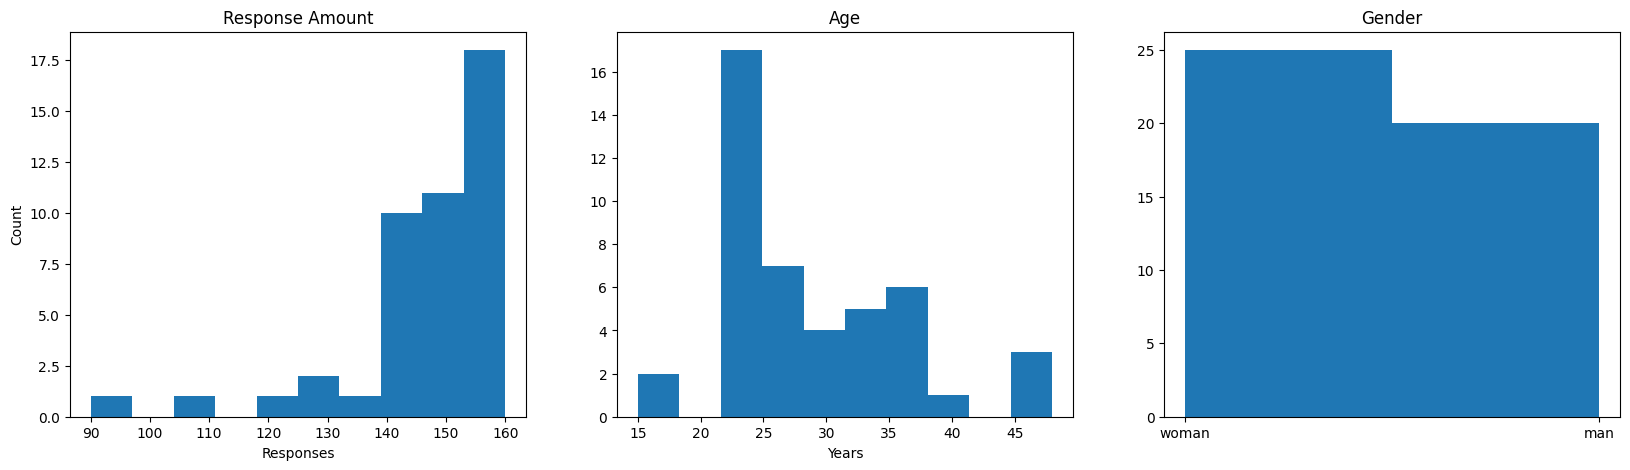

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].hist(df["total_response_amount"], bins=10)
axs[0].set_title("Response Amount")
axs[0].set_xlabel("Responses")
axs[0].set_ylabel("Count")
axs[1].hist(df["age"], bins=10)
axs[1].set_title("Age")
axs[1].set_xlabel("Years")
axs[2].hist(df["gender"], bins=2)
axs[2].set_title("Gender")

### Figuras del paper

## Figure 2 / Table 2. Effects of the Different Manipulations on the Mean and Dispersion of RT

A. Cambios en el promedio de RT de la tarea de números cuando el delay == 1025 para diferentes manipulaciones experimentales. Cambiar la notación hace al RT mas lento, y dentro de esa condición, las respuestas son mas lentas para distancias cortas que largas. La diferencia ente las condiciones de distancia cercana o lejana es independiente de la manipulación experimental.

B. A different pattern is observed for the interquartile range, which provides a measure of dispersion. While distance manipulation results in a
major change of the interquartile range, there is not a major effect of notation or response complexity.

In [127]:
# get DF (RT_digits_close, RT_digits_far, RT_words_close, RT_words_far) FOR ONLY delay == 1025
indexes = ["name", "RT", "distance", "notation"]

mean_RT_delay_1025 = pd.DataFrame()
name_idx = 0
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df.dropna(subset=['rt_1'])
        file_df = file_df.dropna(subset=['rt_2'])
        percentage = (file_df['rt_1'] > file_df['delay']).mean()
        if percentage >=.8:
            print(f"Delay < RT_1 for {file}")
            continue
        file_df = file_df[file_df["delay"] == 1025]
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        if (file_df['rt_2_accum'].mean() > 2000):
            print(f"rt2 > 2000 for {file}")
            continue
        file_df["name"] = name_idx
        mean_RT_delay_1025 = pd.concat([
            mean_RT_delay_1025, pd.concat([
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2.mean()).rename(columns={"rt_2": "rt_2_mean"}),
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2_accum.mean()).rename(columns={"rt_2_accum": "rt_2_accum_mean"}),
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2_accum.apply(lambda x: x.quantile(0.75) - x.quantile(0.25))).rename(columns={"rt_2_accum": "interquartile_range"})], 
                axis=1).reset_index().set_index(["notation", "distance", "name"])

            ], axis=0)
        name_idx += 1
#mean_RT_delay_1025["file"] = corpus_files
mean_RT_delay_1025 = mean_RT_delay_1025.reset_index()

Delay < RT_1 for 190.190.193.126_2023-11-01_Mujer_Derecha_26.csv
rt2 > 2000 for 190.188.115.65_2023-10-31_Mujer_Derecha_29.csv
Delay < RT_1 for 186.13.97.33_2023-11-01_Mujer_Derecha_43.csv
Delay < RT_1 for 152.168.59.172_2023-10-27_Hombre_Derecha_23.csv
Delay < RT_1 for 190.193.233.86_2023-10-25_Hombre_Derecha_32.csv
Delay < RT_1 for 181.44.118.207_2023-11-02_Mujer_Derecha_23.csv
Delay < RT_1 for 170.0.86.223_2023-10-25_Mujer_Derecha_33.csv


In [128]:
mean_RT_delay_1025

,notation,distance,name,rt_2_mean,rt_2_accum_mean,interquartile_range
0,digit,close,0,629.250000,1654.250000,120.75
1,digit,far,0,669.400000,1694.400000,222.50
2,word,close,0,847.875000,1872.875000,266.75
3,word,far,0,725.750000,1750.750000,145.00
4,digit,close,1,734.900000,1759.900000,70.00
...,...,...,...,...,...,...
171,word,far,42,803.250000,1828.250000,176.25
172,digit,close,43,577.000000,1602.000000,154.00
173,digit,far,43,503.444444,1528.444444,51.00
174,word,close,43,700.083333,1725.083333,131.25


In [129]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [130]:
mean_RT_delay_1025

,notation,distance,name,rt_2_mean,rt_2_accum_mean,interquartile_range
0,digit,close,0,629.250000,1654.250000,120.75
1,digit,far,0,669.400000,1694.400000,222.50
2,word,close,0,847.875000,1872.875000,266.75
3,word,far,0,725.750000,1750.750000,145.00
4,digit,close,1,734.900000,1759.900000,70.00
...,...,...,...,...,...,...
171,word,far,42,803.250000,1828.250000,176.25
172,digit,close,43,577.000000,1602.000000,154.00
173,digit,far,43,503.444444,1528.444444,51.00
174,word,close,43,700.083333,1725.083333,131.25


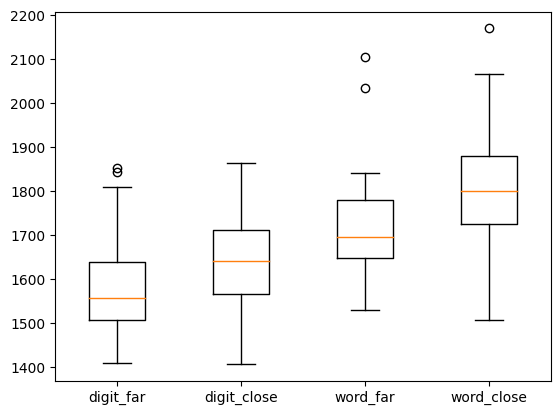

In [131]:
# plot a single figure with 4 bosplots (rt digit_close, rt digit_far, rt word_close, rt word_far)
filter_notation_distance = lambda n, d: mean_RT_delay_1025.loc[(mean_RT_delay_1025["notation"] == n) & (mean_RT_delay_1025["distance"] == d)]["rt_2_accum_mean"].values

digits_far = filter_notation_distance("digit", "far")
digits_close = filter_notation_distance("digit", "close")
words_far = filter_notation_distance("word", "far")
words_close = filter_notation_distance("word", "close")

plt.boxplot([digits_far, digits_close, words_far, words_close], labels=["digit_far", "digit_close", "word_far", "word_close"])
plt.show()


In [132]:
mean_RT_delay_1025[10:30]


,notation,distance,name,rt_2_mean,rt_2_accum_mean,interquartile_range
10,word,close,2,629.454545,1654.454545,130.00
11,word,far,2,625.375000,1650.375000,197.25
12,digit,close,3,566.700000,1591.700000,177.75
13,digit,far,3,537.666667,1562.666667,192.00
14,word,close,3,676.875000,1701.875000,137.75
15,word,far,3,599.727273,1624.727273,89.00
16,digit,close,4,579.625000,1604.625000,109.00
17,digit,far,4,432.500000,1457.500000,65.25
18,word,close,4,593.222222,1618.222222,71.00
19,word,far,4,537.818182,1562.818182,100.50


In [87]:
anova_tableRM = anova_lm(ols("rt_2_mean ~ C(notation) * C(distance, Treatment('far')) + C(name)", mean_RT_delay_1025).fit(), typ=2)
anova_tableRM

,sum_sq,df,F,PR(>F)
C(notation),1.121234e+06,1.0,195.080188,8.741468e-28
"C(distance, Treatment('far'))",2.662014e+05,1.0,46.315609,3.192610e-10
C(name),1.923445e+06,44.0,7.605787,5.107302e-20
"C(notation):C(distance, Treatment('far'))",1.116401e+04,1.0,1.942394,1.657509e-01
Residual,7.586771e+05,132.0,NaN,NaN


In [88]:
anova_tableRM2 = anova_lm(ols("interquartile_range ~ C(notation) * C(distance, Treatment('far')) + C(name)", mean_RT_delay_1025).fit(), typ=2)
anova_tableRM2

,sum_sq,df,F,PR(>F)
C(notation),75031.250000,1.0,10.246454,0.001716
"C(distance, Treatment('far'))",106531.338889,1.0,14.548185,0.000209
C(name),803691.600694,44.0,2.494412,0.000034
"C(notation):C(distance, Treatment('far'))",120.050000,1.0,0.016394,0.898312
Residual,966590.454861,132.0,NaN,NaN


In [15]:
anova_table2
#anova_table.loc['C(notation)', 'F']

NameError: name 'anova_table2' is not defined

In [ ]:
anova_table1 = anova_table1.rename(index={"C(distance, Treatment('far'))": "distance"})
anova_table2 = anova_table2.rename(index={"C(notation):C(distance, Treatment('far'))": "notation_distance"})
anova_table3 = anova_table3.rename(index={"C(distance, Treatment('far'))": "distance"})
anova_table4 = anova_table4.rename(index={"C(notation):C(distance, Treatment('far'))": "notation_distance"})

In [ ]:
results = pd.DataFrame(columns=["Task Manipulation", "Effect", "Mean", "Interquartile Range"])
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect", 
                                    f"F={anova_table1.loc['C(notation)', 'F']}, p={anova_table1.loc['C(notation)', 'PR(>F)']}", 
                                    f"F={anova_table3.loc['C(notation)', 'F']}, p={anova_table3.loc['C(notation)', 'PR(>F)']}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect of distance", 
                                    f"F={anova_table1.loc['distance', 'F']}, p={anova_table1.loc['distance', 'PR(>F)']}",
                                    f"F={anova_table3.loc['distance', 'F']}, p={anova_table3.loc['distance', 'PR(>F)']}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Interaction", 
                                    f"F={anova_table2.loc['notation_distance', 'F']}, p={anova_table2.loc['notation_distance', 'PR(>F)']}",
                                    f"F={anova_table4.loc['notation_distance', 'F']}, p={anova_table4.loc['notation_distance', 'PR(>F)']}"]

results


,Task Manipulation,Effect,Mean,Interquartile Range
0,Effect of notation,Main effect,"F=47.00333436162546, p=8.52068318685329e-11","F=3.3301429274855314, p=0.06950538504052996"
1,Effect of notation,Main effect of distance,"F=10.325149942741593, p=0.0015286244684478442","F=7.631875253289698, p=0.006266589768766271"
2,Effect of notation,Interaction,"F=19.268956605720945, p=5.131318083601494e-11","F=3.883269244311608, p=0.009970523393495504"


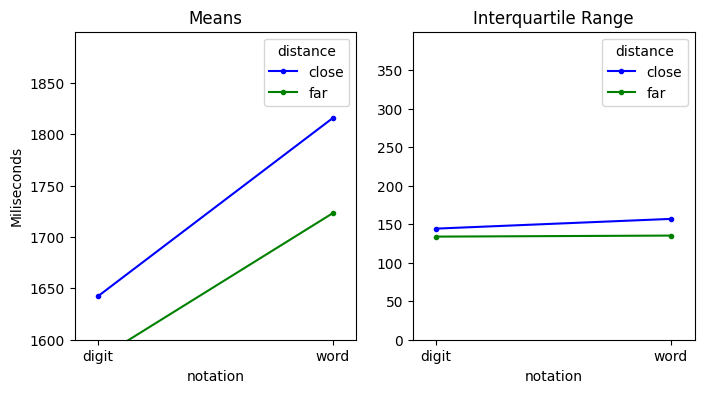

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].set_ylim([1600, 1900])
ax[0].set_yticks(range(1600, 1900, 50))

ax[1].set_ylim([0, 400])
ax[1].set_yticks(range(0, 400, 50))

ax[0].set_xticks(range(2))
ax[0].set_xticklabels(['Digits', 'Words'])
ax[1].set_xticks(range(2))
ax[1].set_xticklabels(['Digits', 'Words'])

ax[0].set_title('Means')
ax[1].set_title('Interquartile Range')

# y axis label

# interaction plot for mean
interaction_plot(mean_RT_delay_1025["notation"], mean_RT_delay_1025["distance"], mean_RT_delay_1025["rt_2_accum_mean"], ax=ax[0], colors=['blue', 'green'])

# interaction plot for interquartile range
# calculate interquartile range for each group
interquartile_range = mean_RT_delay_1025.groupby(["notation", "distance"]).rt_2_accum_mean.apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).to_frame()
interquartile_range = interquartile_range.reset_index()
interquartile_range.columns = ["notation", "distance", "interquartile_range"]
interaction_plot(interquartile_range["notation"], interquartile_range["distance"], interquartile_range["interquartile_range"], ax=ax[1], colors=['blue', 'green'])


ax[0].set_ylabel('Miliseconds')
ax[1].set_ylabel('')



plt.show()


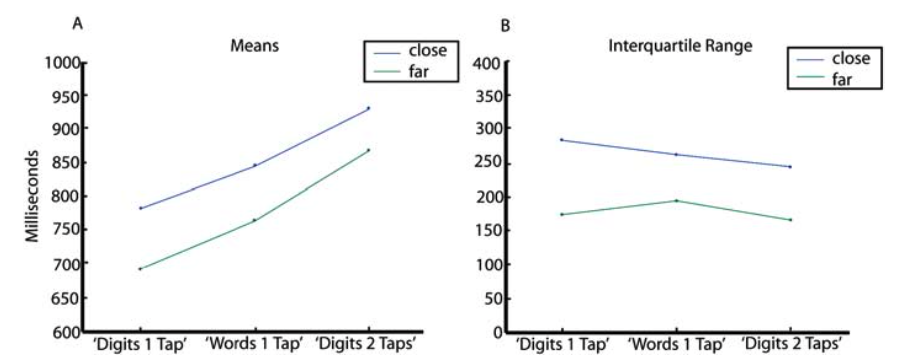

Delay < RT_1 for 190.190.193.126_2023-11-01_Mujer_Derecha_26.csv
rt2 > 2000 for 190.188.115.65_2023-10-31_Mujer_Derecha_29.csv
Delay < RT_1 for 152.168.59.172_2023-10-27_Hombre_Derecha_23.csv
Delay < RT_1 for 190.193.233.86_2023-10-25_Hombre_Derecha_32.csv
Delay < RT_1 for 181.44.118.207_2023-11-02_Mujer_Derecha_23.csv
Delay < RT_1 for 170.0.86.223_2023-10-25_Mujer_Derecha_33.csv


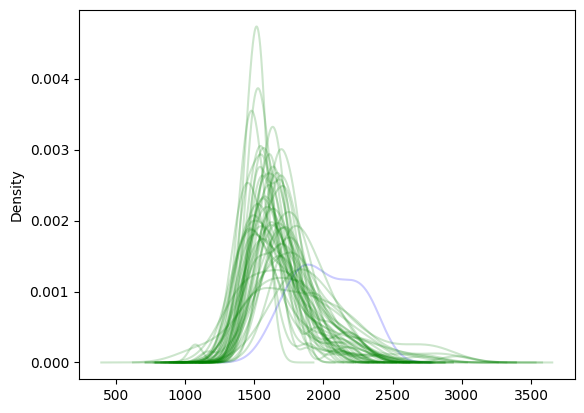

In [133]:
# plotear hist acumulado de todos los sujetos y ver que onda el ruido
from matplotlib import pyplot

#bins = numpy.linspace(-10, 10, 100)
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df[file_df["delay"] == 1025]
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        # # Find the cases where rt_2_accum is larger than 2000 ms half of the time
        percentage = (file_df['rt_1'] > file_df['delay']).mean()
        if percentage >=.8:
            print(f"Delay < RT_1 for {file}")
            continue

        if (file_df['rt_2_accum'].mean() > 2000):
            file_df.rt_2_accum.plot.density(color='b',alpha=0.2)
            print(f"rt2 > 2000 for {file}")
        else:
            file_df.rt_2_accum.plot.density(color='green',alpha=0.2)


pyplot.show()

In [ ]:
mean_notation_RTs = pd.DataFrame()
mean_distance_RTs = pd.DataFrame()
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        # notation
        rt1_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_1.mean())
        # rt2 in reality is delay + rt2
        rt2_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_2_accum.mean())
        mean_notation_RTs = pd.concat([mean_notation_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)
        # distance
        rt1_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_1.mean())
        rt2_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_2_accum.mean())
        mean_distance_RTs = pd.concat([mean_distance_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)

mean_notation_RTs = mean_notation_RTs.reset_index()
mean_distance_RTs = mean_distance_RTs.reset_index()

In [ ]:
mean_notation_RTs

,notation,delay,rt_1,rt_2_accum
0,digit,0.0,975.933333,1320.133333
1,digit,102.5,790.875000,1101.687500
2,digit,992.5,763.425000,1621.289474
3,digit,1025.0,752.555556,1676.555556
4,word,0.0,836.500000,1318.625000
...,...,...,...,...
403,digit,1025.0,672.800000,1568.900000
404,word,0.0,746.800000,1075.277778
405,word,102.5,637.300000,1050.150000
406,word,992.5,547.500000,1725.250000


In [ ]:
mean_notation_RTs.groupby(["notation", "delay"]).rt_1.mean()

notation  delay 
digit     0.0       843.882554
          102.5     867.537111
          992.5     864.638637
          1025.0    848.928467
word      0.0       888.396324
          102.5     905.499449
          992.5     888.608425
          1025.0    891.167251
Name: rt_1, dtype: float64

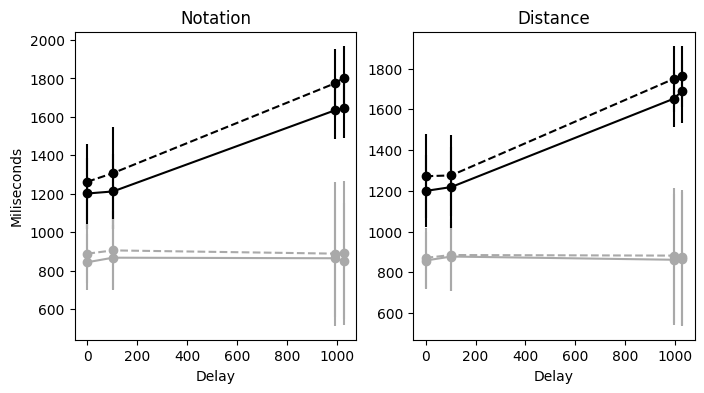

In [ ]:
# show a figure with two subplots
# subplot 1: Scatter plot with mean RTs for each delay (x axis) and notation (color) 
# subplot 2: Scatter plot with mean RTs for each delay (x axis) and distance (color)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# add scatter plot with lines for mean_notation_RTs with notation as color and line properties
for notation in ["digit", "word"]:
    rt_1_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.mean().reset_index()
    rt_1_std = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.std().reset_index()

    rt_2_accum_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.mean().reset_index()
    rt_2_accum_std = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.std().reset_index()

    # scatter with error bars
    fmt_line = 'o-' if notation == "digit" else 'o--'
    
    ax[0].errorbar( rt_1_mean[rt_1_mean["notation"] == notation]["delay"], 
                    rt_1_mean[rt_1_mean["notation"] == notation]["rt_1"], 
                    yerr=rt_1_std[rt_1_std["notation"] == notation]["rt_1"], 
                    fmt=fmt_line, label=notation, color="darkgray")

    ax[0].errorbar( rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["rt_2_accum"], 
                    yerr=rt_2_accum_std[rt_2_accum_std["notation"] == notation]["rt_2_accum"], 
                    fmt=fmt_line, label=notation, color="black")

for distance in ["close", "far"]:
    rt_1_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.mean().reset_index()
    rt_1_std = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.std().reset_index() # TODO: cambiar por error estandar

    rt_2_accum_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.mean().reset_index()
    rt_2_accum_std = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.std().reset_index()

    # scatter with error bars
    fmt_line = 'o-' if distance == "far" else 'o--'
    
    ax[1].errorbar( rt_1_mean[rt_1_mean["distance"] == distance]["delay"], 
                    rt_1_mean[rt_1_mean["distance"] == distance]["rt_1"], 
                    yerr=rt_1_std[rt_1_std["distance"] == distance]["rt_1"], 
                    fmt=fmt_line, label=distance, color="darkgray")

    ax[1].errorbar( rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["rt_2_accum"], 
                    yerr=rt_2_accum_std[rt_2_accum_std["distance"] == distance]["rt_2_accum"], 
                    fmt=fmt_line, label=distance, color="black")
    

ax[0].set_title('Notation')
ax[0].set_ylabel('Miliseconds')
ax[0].set_xlabel('Delay')

ax[1].set_title('Distance')
ax[1].set_ylabel('')
ax[1].set_xlabel('Delay')

plt.show()

# Cambiar std por error estandar /sqrt(n)




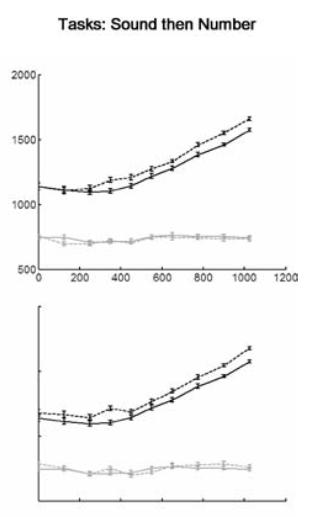

##  Figure 5

Thus, our purpose was to test the prediction of our model that the notation and response-complexity manipulations should affect the parameter $t_0$ while the distance manipulation should affect the parameter $\alpha$.

$$g(t) = \frac{1}{\sigma \cdot \sqrt{2\pi \cdot (t-t_0)^3}} \cdot \exp(-\frac{(1-\alpha\cdot (t-t_0))^2}{2\cdot \sigma^2(t-t_0)})$$

In [46]:
# for each subject, 
# keep delay == 1025
# separate (digit,far), (digit,close), (word,far), (word,close)
# and fit \alpha, t_0 (sigma=0.018), save it on a df
RTs_1025 = pd.DataFrame()
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")

        file_df = file_df[file_df["delay"] == 1025]
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df = file_df[file_df["rt_2"].notna()]
        file_df["name"] = file.split(".")[-2]
        RTs_1025 = pd.concat([RTs_1025, file_df], axis=0)

In [48]:
list(RTs_1025.groupby(["notation", "distance"]).rt_2)[0][1].values

array([ 562.,  630.,  657.,  515.,  824.,  734.,  536.,  576.,  920.,
        609.,  610., 1140.,  661.,  646.,  666.,  729.,  676.,  692.,
        561.,  648.,  691.,  389.,  448.,  452.,  663.,  997.,  461.,
        751.,  442.,  453.,  652.,  593.,  614.,  547.,  476.,  678.,
        558.,  650.,  679.,  587.,  475.,  645.,  474.,  569.,  982.,
        688.,  461.,  415.,  482.,  655.,  427.,  868.,  570.,  512.,
        747.,  409.,  423.,  489.,  404.,  404.,  362.,  448.,  359.,
        408.,  313.,  697.,  682.,  555.,  514.,  801.,  570.,  514.,
        500.,  665.,  586.,  426.,  492.,  500.,  611.,  805.,  707.,
        706.,  751.,  493.,  858.,  899.,  609.,  582.,  479.,  648.,
         50.,  399.,  511.,  429.,  487.,  413., 1239., 1388.,  939.,
        750.,  837.,  730., 1610., 1523.,  758.,  790.,  886.,  846.,
       1368.,  867., 1259.,  862.,  753., 1121.,  728.,  598., 1174.,
        404.,  414.,  393.,  403.,  411.,  374.,  554.,  704., 1104.,
        688., 1564.,

In [49]:
# histogram values of list(file_df.groupby(["notation", "distance"]).rt_2)[0][1].values 
import numpy as np
np.histogram(list(RTs_1025.groupby(["notation", "distance"]).rt_2)[0][1].values, bins=100)

(array([ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  2,  3,
         3,  4,  8, 12, 16, 15,  8, 15, 18, 24, 14, 22, 14, 20, 18, 18, 17,
        15,  7, 18, 12, 20, 15,  9,  9, 10,  7, 10,  7,  4,  3,  6,  8,  3,
         4,  3,  4,  4,  6,  2,  3,  2,  2,  0,  2,  3,  2,  3,  2,  2,  1,
         2,  0,  0,  0,  1,  3,  0,  0,  0,  0,  2,  1,  1,  1,  0,  0,  1,
         0,  0,  0,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  1]),
 array([  50.  ,   66.45,   82.9 ,   99.35,  115.8 ,  132.25,  148.7 ,
         165.15,  181.6 ,  198.05,  214.5 ,  230.95,  247.4 ,  263.85,
         280.3 ,  296.75,  313.2 ,  329.65,  346.1 ,  362.55,  379.  ,
         395.45,  411.9 ,  428.35,  444.8 ,  461.25,  477.7 ,  494.15,
         510.6 ,  527.05,  543.5 ,  559.95,  576.4 ,  592.85,  609.3 ,
         625.75,  642.2 ,  658.65,  675.1 ,  691.55,  708.  ,  724.45,
         740.9 ,  757.35,  773.8 ,  790.25,  806.7 ,  823.15,  839.6 ,
         856.05,  872.5 ,  888.95,  905.4 ,  921.85, 

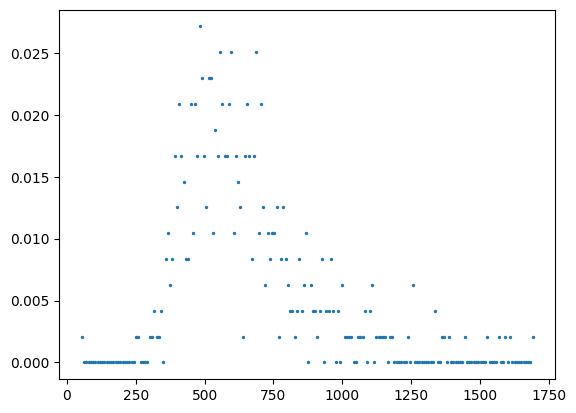

In [58]:
# plot np.histogram(list(file_df.groupby(["notation", "distance"]).rt_2)[0][1].values, bins=20)
hist, bins = np.histogram(list(RTs_1025.groupby(["notation", "distance"]).rt_2)[0][1].values, bins=200)
# transform to probability
hist = hist / sum(hist)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# show scatter plot with the histogram
plt.scatter(center, hist, s=2)
plt.show()


In [52]:
sorted(list(file_df.groupby(["notation", "distance"]).rt_2)[0][1].values)

[468.0, 479.0, 499.0, 505.0, 529.0, 582.0, 592.0, 630.0, 682.0, 690.0, 691.0]

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import math

# Your model function
def g(t, alpha, t0):
    denominador = 0.018 * math.sqrt(2 * math.pi * (t - t0)**3)
    numerador_expo = (1 - alpha * (t - t0)**2)
    denominador_expo = (2 * 0.018**2 * (t - t0))
    return 1 / denominador * math.exp(- (numerador_expo / denominador_expo))

# Example data (you should replace this with your actual data)
t_data = np.linspace(1, 10, 100)  # Example t values
observed_data = np.random.normal(g(t_data, 0.5, 5), 0.1)  # Example observed data with some noise

# Curve fitting
popt, pcov = curve_fit(g, t_data, observed_data, bounds=(0, [1., 10.]))
alpha_opt, t0_opt = popt

print(f"Optimal alpha: {alpha_opt}, Optimal t0: {t0_opt}")


In [30]:
def g(t, alpha, t0):
    denominador = 0.018*math.sqrt(2*math.pi * (t-t0)**3)
    numerador_expo = (1-alpha*(t-t0)**2)
    denominador_expo = (2*0.018**2*(t-t0))
    return 1/(denominador) * math.exp(- (numerador_expo/denominador_expo))

In [28]:
for f in file_df.groupby(["notation", "distance"]).rt_2:
    print(f[1].values)

[558. 650. 679. 587. 475. 645. 474. 569.]
[423. 499. 438. 490. 459. 440. 451. 407. 385. 504. 338. 356.]
[505. 509. 569. 858. 539. 488. 580. 727. 564.]
[524. 614. 620. 545. 512. 438. 655. 471. 443. 570. 524.]


In [23]:
# Segun Juan la figura 6 corresponde solamente a un sujeto. Tomar solo uno, si vemos que tenemos pocos datos veamos que pasa usando todos los sijeto (no debería funcionar ya que hay mucho ruido/varianza)
subject = 4
subject_file = corpus_files[subject]
assert subject_file.endswith(".csv")

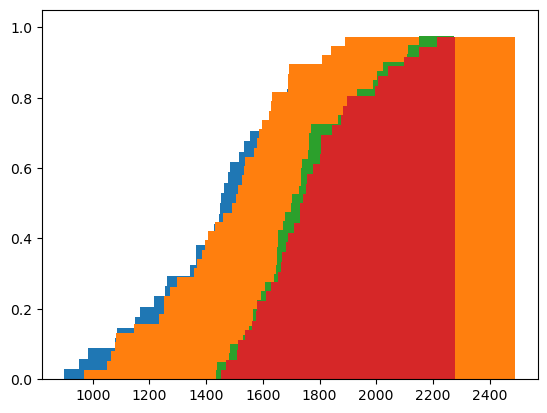

In [24]:
file_df = pd.read_csv(f"{corpus_dir}/{subject_file}")
file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
delays = [0, 102.5, 992.5, 1025.0]
delays_attr = {d:plt.hist(file_df[file_df["delay"] == d]["rt_2_accum"] , bins=1000, density=True, cumulative=True) for d in delays} # n, bins, patches
delays_attr_scatter = {d: ([0.5 * (bins[i] + bins[i+1]) for i in range(len(n))], n) for d, (n, bins, patches) in delays_attr.items()}

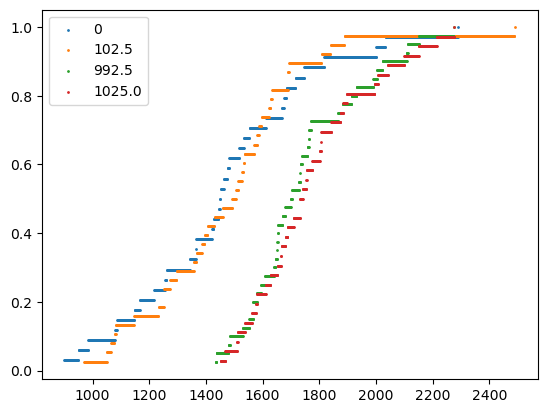

In [25]:
for d, (bins_mean, n) in delays_attr_scatter.items():
    plt.scatter(bins_mean, n, label = d, s=1)

plt.legend()

t_0, \alpha, \sigma, T 

Parameters of the mathematical model used to fit the distributions of RTs to the first task. The model we use is a simple variant of a general class of models known as random-walk models. Briefly, the model supposes a fixed delay (t_0) followed by a stochastic ac- cumulation of evidence with a fixed drift rate (\alpha) and added Gaussian noise (whose amplitude is determined by the "diffusion constant" \sigma), which stops once it hits a threshold level (T).

In [ ]:
from scipy.stats import invgauss

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html